In [1]:
%load_ext autoreload
%autoreload 2

# Preparing dataset for analysis

This notebook modifies the dataset gathers for the work in Schwalbe-Koda et al., Science (2021) DOI: [10.1126/science.abh3350](https://www.science.org/doi/full/10.1126/science.abh3350) and prepares it for the analysis done in this work.

## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from analysis_functions import (
    SYNTH_TEMP,
    add_competition_or_directivity_softmax,
    compute_zeo_ads_entropy,
    get_num_atoms,
    my_mpl_settings,
    templating_energy,
)

In [3]:
my_mpl_settings()

In [4]:
dsk_df = pd.read_csv("../data/binding_schwalbekoda_science.csv")
dsk_df.head()

,crystal_id,Zeolite,SMILES,InchiKey,Ligand formula,Loading,Binding (SiO2),Binding (OSDA),Directivity (SiO2),Competition (SiO2),Competition (OSDA),Templating,SCScore,Volume (Angstrom3),Axis 1 (Angstrom),Axis 2 (Angstrom),In literature?,Germanosilicate composition?,Zeolite composition?,Zeotype composition?
0,137337790,ACO,CCCCCN,DPBLXKKOBLCELK-UHFFFAOYNA-N,C5H13N,2,-0.792990,-6.343916,13.610253,16.963938,135.894435,19.428617,1.514863,107.680,7.926624,2.444878,0.0,False,False,False
1,137353625,ACO,Cc1ccncc1,FKNQCJSGGFJEIZ-UHFFFAOYNA-N,C6H7N,2,-3.000776,-24.006207,11.402466,16.312994,104.841808,18.325914,NaN,96.232,4.708724,4.317600,0.0,False,False,False
2,137369986,ACO,NCCOCCO,GIAFURWZWWWBQT-UHFFFAOYNA-N,C4H11NO2,3,-7.733204,-41.243755,6.670038,12.812365,109.974071,15.525417,1.493216,108.720,6.730158,3.173863,0.0,False,False,False
3,137352553,ACO,CCNCC,HPNMFZURTQLUMO-UHFFFAOYNA-N,C4H11N,2,-2.536347,-20.290778,11.866895,15.167858,95.902317,18.026902,1.082016,91.104,6.692582,2.429795,0.0,False,False,False
4,139638010,ACO,CCCCN,HQABUPZFAYXKJW-UHFFFAOYNA-N,C4H11N,3,-1.885987,-10.058597,12.517255,17.667573,120.006328,19.195592,1.282441,90.800,6.676878,2.528606,0.0,False,False,False


In [5]:
# entropies of gas phase molecules in kJ/mol/K with symmetry numbers
entropy_df = pd.read_csv("../data/gas_entropy.csv")
entropy_df.head()

,SMILES,rotational_entropy,one_dim_trans_entropy,symmetry
0,CCCCCN,0.117462,0.056883,1.0
1,Cc1ccncc1,0.116193,0.057158,1.0
2,NCCOCCO,0.121876,0.057663,1.0
3,CCNCC,0.111881,0.056154,1.0
4,CCCCN,0.112314,0.056154,1.0


In [6]:
form_df = pd.read_csv("../data/form_E.csv")
form_df.head()

,job,crystal_id,framework,stoichiometry,energies,Si_count,formation_E
0,35296704,59490944,PUN,O72Si36,-31.645161,36,19.520386
1,78516488,137469541,ETV,O28Si14,-12.345867,14,12.128671
2,35323177,59490878,IWV-supercell,O304Si152,-133.934804,152,13.960178
3,35296586,59490777,AET,O144Si72,-63.499479,72,11.893431
4,35296599,59490796,ATS,O48Si24,-21.166126,24,11.933595


In [7]:
# turn the entropy dataframe into a dictionary with SMILES as keys
entropy_dict = entropy_df.set_index("SMILES").to_dict()

In [8]:
dsk_df.columns

Index(['crystal_id', 'Zeolite', 'SMILES', 'InchiKey', 'Ligand formula',
       'Loading', 'Binding (SiO2)', 'Binding (OSDA)', 'Directivity (SiO2)',
       'Competition (SiO2)', 'Competition (OSDA)', 'Templating', 'SCScore',
       'Volume (Angstrom3)', 'Axis 1 (Angstrom)', 'Axis 2 (Angstrom)',
       'In literature?', 'Germanosilicate composition?',
       'Zeolite composition?', 'Zeotype composition?'],
      dtype='object')

In [9]:
dsk_df = dsk_df.drop(
    columns=[
        "InchiKey",
        "SCScore",
        "Axis 1 (Angstrom)",
        "Axis 2 (Angstrom)",
        "Germanosilicate composition?",
        "Zeolite composition?",
        "Zeotype composition?",
    ]
)
len(dsk_df)

112426

In [10]:
dsk_df = dsk_df.dropna()
len(dsk_df)

112421

In [11]:
name_mapper = {
    "Binding (OSDA)": "dE_Om",
    "Binding (SiO2)": "dE_S",
    "In literature?": "syn",
}

dsk_df = dsk_df.rename(columns=name_mapper)

In [12]:
dsk_df["ligand_atoms"] = dsk_df["Ligand formula"].apply(get_num_atoms)
dsk_df["dE_Oa"] = dsk_df["dE_Om"] / dsk_df["ligand_atoms"]

In [13]:
# drop rows where zeolite not in form_df
dsk_df = dsk_df[dsk_df["Zeolite"].isin(form_df["framework"])]

In [14]:
dsk_df["E_F"] = dsk_df["Zeolite"].apply(
    lambda x: form_df[form_df["framework"] == x]["formation_E"].iloc[0]
)

In [15]:
dsk_df["entropy_trans"] = dsk_df["SMILES"].apply(
    lambda x: entropy_dict["one_dim_trans_entropy"].get(x)
)
dsk_df["entropy_rot"] = dsk_df["SMILES"].apply(lambda x: entropy_dict["rotational_entropy"].get(x))
dsk_df["symmetry"] = dsk_df["SMILES"].apply(lambda x: entropy_dict["symmetry"].get(x, 1))

In [16]:
dsk_df["dS_ads"] = dsk_df[["Zeolite", "entropy_trans", "entropy_rot"]].apply(
    lambda x: compute_zeo_ads_entropy(*x), axis=1
)

In [17]:
dsk_df.columns

Index(['crystal_id', 'Zeolite', 'SMILES', 'Ligand formula', 'Loading', 'dE_S',
       'dE_Om', 'Directivity (SiO2)', 'Competition (SiO2)',
       'Competition (OSDA)', 'Templating', 'Volume (Angstrom3)', 'syn',
       'ligand_atoms', 'dE_Oa', 'E_F', 'entropy_trans', 'entropy_rot',
       'symmetry', 'dS_ads'],
      dtype='object')

In [18]:
dsk_df["Si_count"] = round(dsk_df["dE_Om"] * dsk_df["Loading"] / dsk_df["dE_S"])

In [19]:
dsk_df["TdS_ads"] = dsk_df["dS_ads"] * SYNTH_TEMP
dsk_df = dsk_df.dropna()

In [20]:
dsk_df["dA_Om"] = dsk_df["dE_Om"] - dsk_df["TdS_ads"]
dsk_df["dA_S"] = (dsk_df["dA_Om"] * dsk_df["Loading"]) / dsk_df["Si_count"]
dsk_df["dA_Oa"] = dsk_df["dA_Om"] / dsk_df["ligand_atoms"]
dsk_df["dA_fS"] = dsk_df["dA_S"] + dsk_df["E_F"]

In [21]:
dsk_df[["dA_Om", "dA_Oa", "dA_S"]].describe()

,dA_Om,dA_Oa,dA_S
count,7.717400e+04,7.717400e+04,7.717400e+04
mean,7.967938e+06,3.160212e+05,4.293632e+05
std,1.222468e+08,5.007652e+06,7.188985e+06
min,-2.467722e+05,-1.483915e+04,-1.657086e+04
25%,-1.048593e+02,-2.853326e+00,-4.957787e+00
50%,-5.252027e+01,-1.721895e+00,-2.304299e+00
75%,4.333194e+01,1.392719e+00,1.959043e+00
max,2.145997e+09,1.416345e+08,1.849934e+08


In [22]:
dsk_df["dE_fOm"] = (
    (dsk_df["dE_Om"] * dsk_df["Loading"]) + (dsk_df["E_F"] * dsk_df["Si_count"])
) / dsk_df["Loading"]
dsk_df["dE_fOa"] = (
    (dsk_df["dE_Om"] * dsk_df["Loading"]) + (dsk_df["E_F"] * dsk_df["Si_count"])
) / (dsk_df["Loading"] * dsk_df["ligand_atoms"])
dsk_df["dE_fS"] = (
    (dsk_df["dE_Om"] * dsk_df["Loading"]) + (dsk_df["E_F"] * dsk_df["Si_count"])
) / dsk_df["Si_count"]

Text(0.5, 0, '$\\mathdefault{\\Delta E_{OSDA}}$ / kJ mol$^{\\mathdefault{-1}}$')

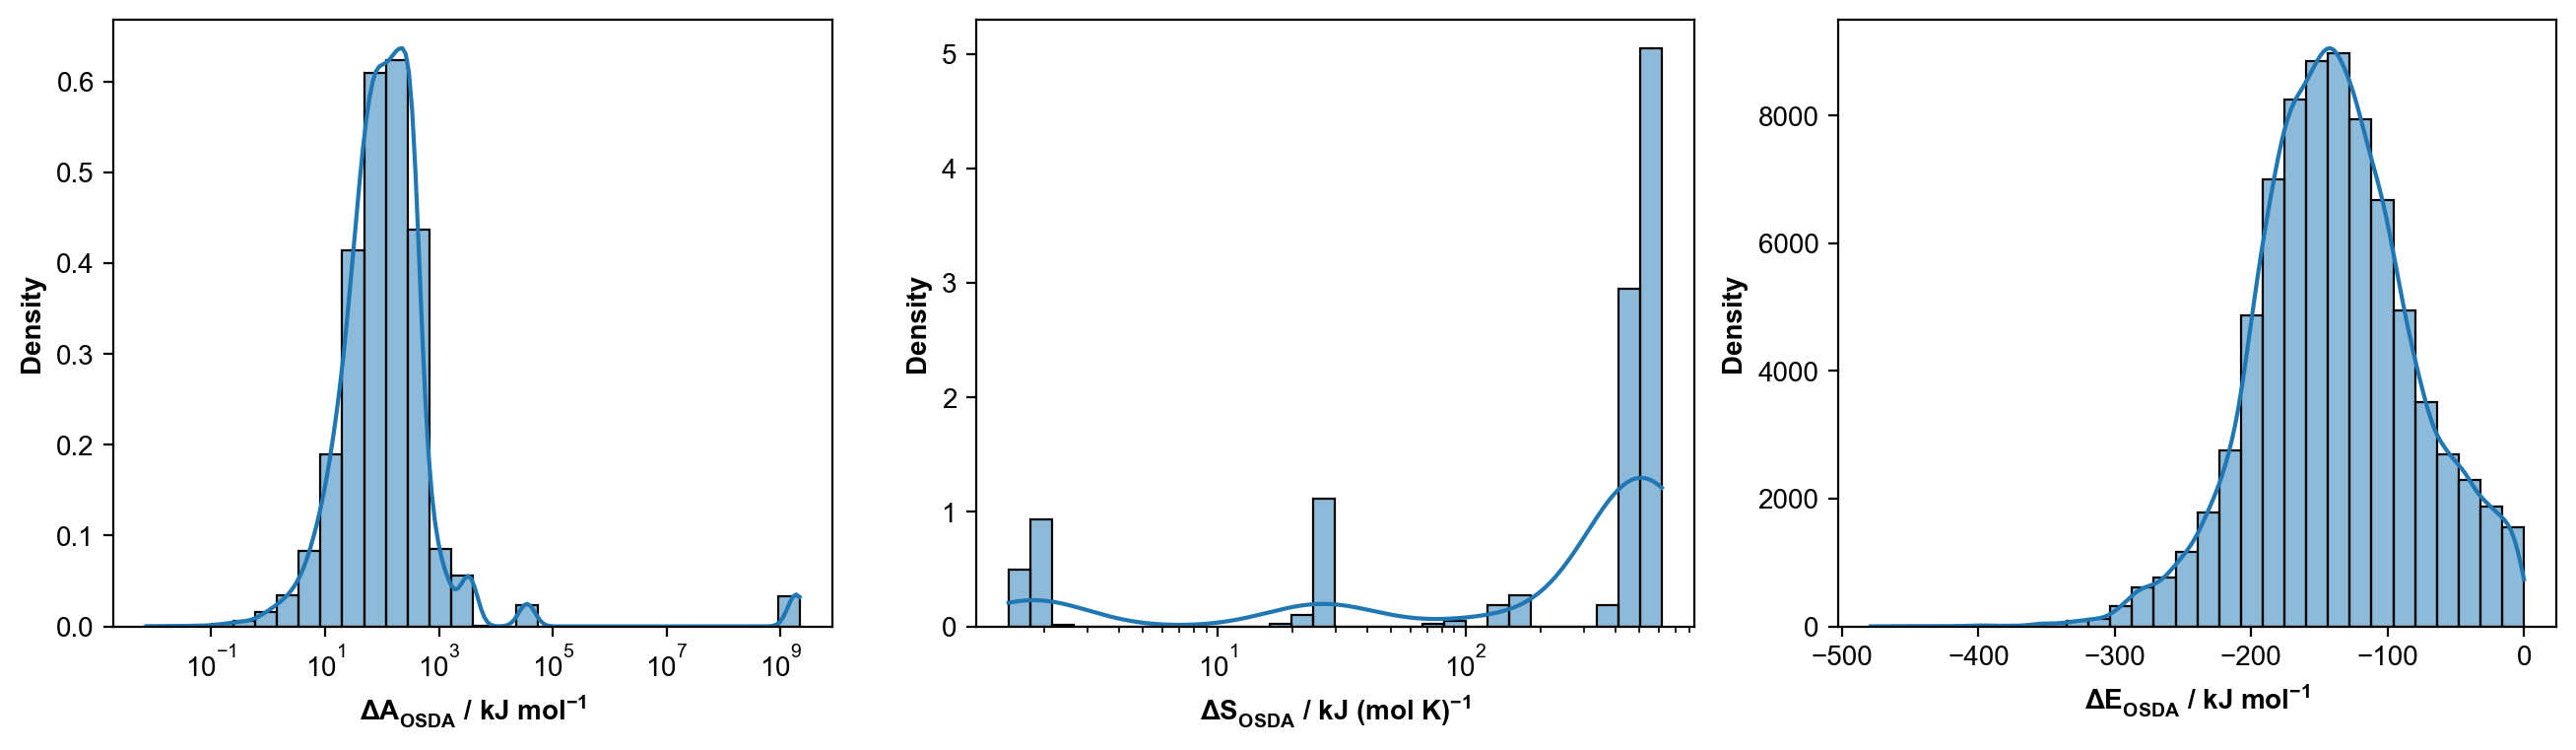

In [23]:
# make a seaborn histogram of the dA_OSDA values, with y-axis as a log scale
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.histplot(dsk_df["dA_Om"], bins=30, kde=True, log_scale=True, ax=axes[0], stat="density")
sns.histplot(dsk_df["dS_ads"], bins=30, kde=True, log_scale=True, ax=axes[1], stat="density")
sns.histplot(dsk_df["dE_Om"], bins=30, kde=True, ax=axes[2])
for ax in axes:
    ax.set_ylabel("Density", fontweight="bold")

axes[0].set_xlabel(
    "$\mathdefault{\Delta A_{OSDA}}$ / kJ mol$^{\mathdefault{-1}}$",  # noqa: W605
    fontweight="bold",
)

axes[1].set_xlabel(
    "$\mathdefault{\Delta S_{OSDA}}$ / kJ (mol K)$^{\mathdefault{-1}}$",  # noqa: W605
    fontweight="bold",
)

axes[2].set_xlabel(
    "$\mathdefault{\Delta E_{OSDA}}$ / kJ mol$^{\mathdefault{-1}}$",  # noqa: W605
    fontweight="bold",
)

In [24]:
dsk_df = dsk_df.drop(dsk_df[dsk_df["dS_ads"] < -10].index)
dsk_df = dsk_df.drop(dsk_df[dsk_df["dS_ads"] > 0].index)
# drop rows where dA_OSDA is larger than 5000
dsk_df = dsk_df.drop(dsk_df[np.abs(dsk_df["dA_Om"]) > 1e3].index)

Text(0.5, 0, '$\\mathdefault{\\Delta E_{OSDA}}$ / kJ mol$^{\\mathdefault{-1}}$')

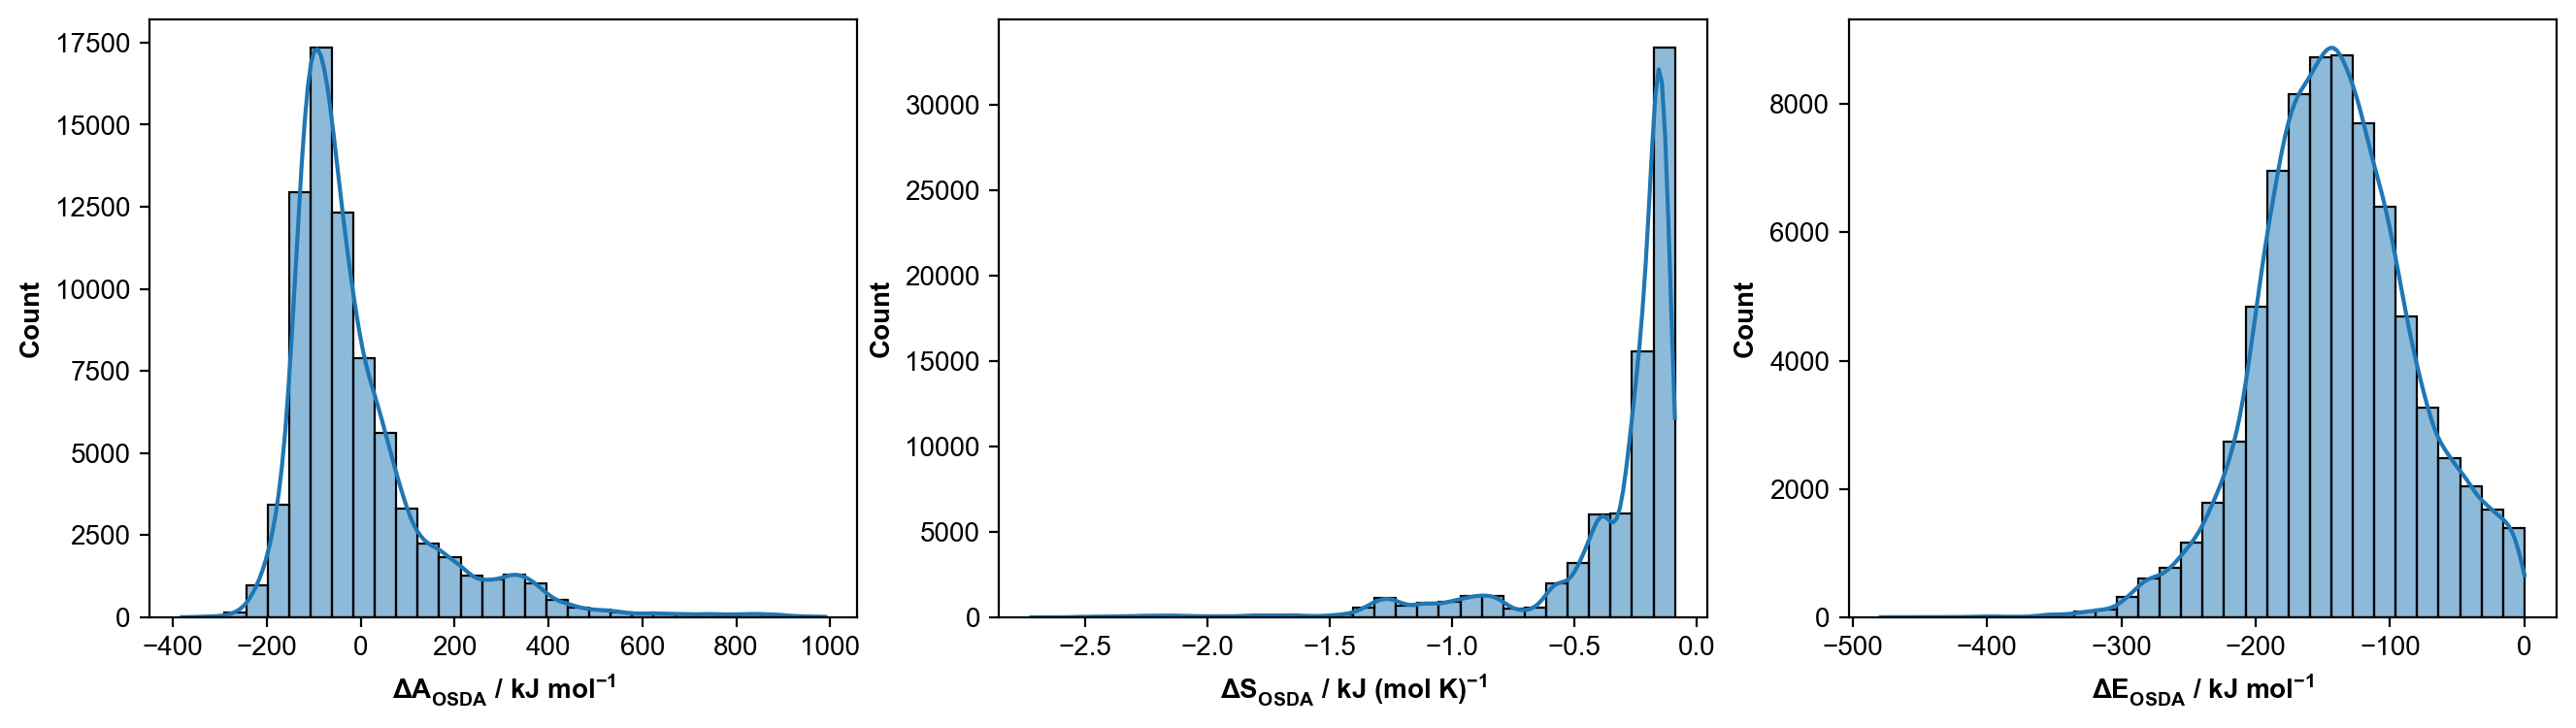

In [25]:
# make a seaborn histogram of the dA_OSDA values, with y-axis as a log scale
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.histplot(dsk_df["dA_Om"], bins=30, kde=True, log_scale=False, ax=axes[0])
sns.histplot(dsk_df["dS_ads"], bins=30, kde=True, log_scale=False, ax=axes[1])
sns.histplot(dsk_df["dE_Om"], bins=30, kde=True, ax=axes[2])
for ax in axes:
    ax.set_ylabel("Count", fontweight="bold")

axes[0].set_xlabel(
    "$\mathdefault{\Delta A_{OSDA}}$ / kJ mol$^{\mathdefault{-1}}$",  # noqa: W605
    fontweight="bold",
)

axes[1].set_xlabel(
    "$\mathdefault{\Delta S_{OSDA}}$ / kJ (mol K)$^{\mathdefault{-1}}$",  # noqa: W605
    fontweight="bold",
)

axes[2].set_xlabel(
    "$\mathdefault{\Delta E_{OSDA}}$ / kJ mol$^{\mathdefault{-1}}$",  # noqa: W605
    fontweight="bold",
)

In [26]:
# add C and D values to the dataframe
dsk_df = add_competition_or_directivity_softmax(dsk_df, "competition", "C_Oa", "dE_Oa")
dsk_df = add_competition_or_directivity_softmax(dsk_df, "competition", "C_Om", "dE_Om")
dsk_df = add_competition_or_directivity_softmax(dsk_df, "competition", "C_S", "dE_S")
dsk_df = add_competition_or_directivity_softmax(dsk_df, "directivity", "D_Oa", "dE_Oa")
dsk_df = add_competition_or_directivity_softmax(dsk_df, "directivity", "D_Om", "dE_Om")
dsk_df = add_competition_or_directivity_softmax(dsk_df, "directivity", "D_S", "dE_S")

  0%|          | 0/134 [00:00<?, ?it/s]

100%|██████████| 1189/1189 [00:09<00:00, 129.01it/s]


In [27]:
# add C and D for Helmholtz free energy
dsk_df = add_competition_or_directivity_softmax(dsk_df, "competition", "C_AOa", "dA_Oa")
dsk_df = add_competition_or_directivity_softmax(dsk_df, "competition", "C_AOm", "dA_Om")
dsk_df = add_competition_or_directivity_softmax(dsk_df, "competition", "C_AS", "dA_S")
dsk_df = add_competition_or_directivity_softmax(dsk_df, "directivity", "D_AOa", "dA_Oa")
dsk_df = add_competition_or_directivity_softmax(dsk_df, "directivity", "D_AOm", "dA_Om")
dsk_df = add_competition_or_directivity_softmax(dsk_df, "directivity", "D_AS", "dA_S")

  0%|          | 0/134 [00:00<?, ?it/s]

100%|██████████| 1189/1189 [00:09<00:00, 127.25it/s]


In [28]:
# add C and D for formation affinities
dsk_df = add_competition_or_directivity_softmax(dsk_df, "competition", "C_fOa", "dE_fOa")
dsk_df = add_competition_or_directivity_softmax(dsk_df, "competition", "C_fOm", "dE_fOm")
dsk_df = add_competition_or_directivity_softmax(dsk_df, "competition", "C_fS", "dE_fS")
dsk_df = add_competition_or_directivity_softmax(dsk_df, "directivity", "D_fOa", "dE_fOa")
dsk_df = add_competition_or_directivity_softmax(dsk_df, "directivity", "D_fOm", "dE_fOm")
dsk_df = add_competition_or_directivity_softmax(dsk_df, "directivity", "D_fS", "dE_fS")

  0%|          | 0/134 [00:00<?, ?it/s]

100%|██████████| 1189/1189 [00:09<00:00, 126.17it/s]


In [29]:
dsk_df.columns

Index(['crystal_id', 'Zeolite', 'SMILES', 'Ligand formula', 'Loading', 'dE_S',
       'dE_Om', 'Directivity (SiO2)', 'Competition (SiO2)',
       'Competition (OSDA)', 'Templating', 'Volume (Angstrom3)', 'syn',
       'ligand_atoms', 'dE_Oa', 'E_F', 'entropy_trans', 'entropy_rot',
       'symmetry', 'dS_ads', 'Si_count', 'TdS_ads', 'dA_Om', 'dA_S', 'dA_Oa',
       'dA_fS', 'dE_fOm', 'dE_fOa', 'dE_fS', 'C_Oa', 'C_Om', 'C_S', 'D_Oa',
       'D_Om', 'D_S', 'C_AOa', 'C_AOm', 'C_AS', 'D_AOa', 'D_AOm', 'D_AS',
       'C_fOa', 'C_fOm', 'C_fS', 'D_fOa', 'D_fOm', 'D_fS'],
      dtype='object')

In [30]:
template_metrics = ["C_Oa", "C_S", "D_Oa", "D_S"]
dsk_df["E_T"] = templating_energy(dsk_df, template_metrics)

In [31]:
form_metrics = ["C_fOa", "C_fS", "D_fOa", "D_fS"]
dsk_df["E_fT"] = templating_energy(dsk_df, form_metrics)

In [32]:
helmholtz_metrics = ["C_AOa", "C_AS", "D_AOa", "D_AS"]
dsk_df["A_T"] = templating_energy(dsk_df, helmholtz_metrics)

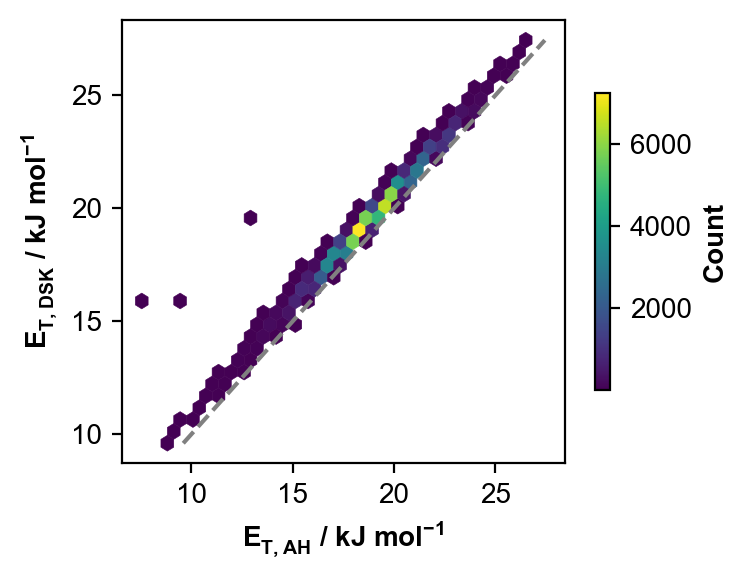

In [33]:
fig, ax = plt.subplots(figsize=(4, 3))

min_template = dsk_df["Templating"].min()
max_template = dsk_df["Templating"].max()
im = ax.hexbin(
    dsk_df["E_T"], dsk_df["Templating"], gridsize=30, cmap="viridis", mincnt=1, linewidths=0.2
)
ax.plot(
    [min_template, max_template],
    [min_template, max_template],
    color="gray",
    linestyle="--",
)
cbar = plt.colorbar(im, shrink=0.67)
cbar.set_label("Count", fontweight="bold")
ax.set_xlabel(
    "$\mathdefault{E_{T, AH}}$ / kJ mol$^{\mathdefault{-1}}$",  # noqa: W605
    fontweight="bold",
)
ax.set_ylabel("$\mathdefault{E_{T, DSK}}$ / kJ mol$^{\mathdefault{-1}}$", fontweight="bold")  # noqa: W605,
ax.set_box_aspect(1)
fig.tight_layout()

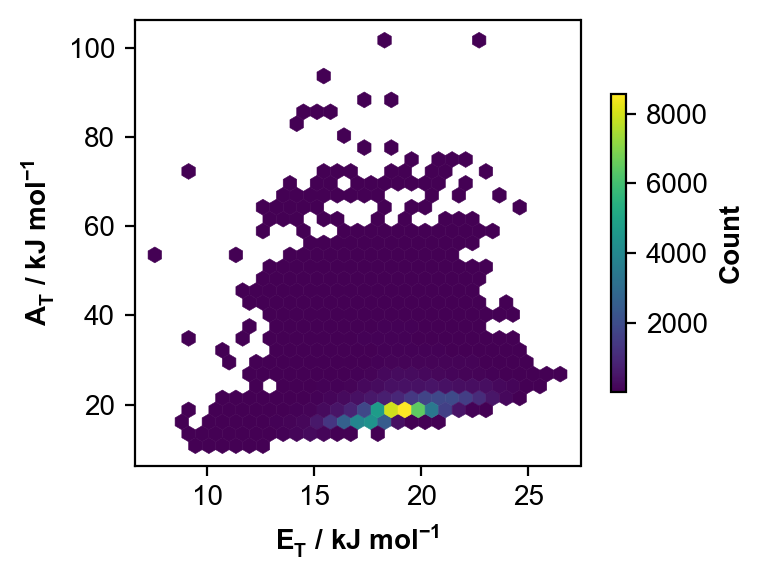

In [34]:
fig, ax = plt.subplots(figsize=(4, 3))

im = ax.hexbin(dsk_df["E_T"], dsk_df["A_T"], gridsize=30, cmap="viridis", mincnt=1, linewidths=0.2)
cbar = plt.colorbar(im, shrink=0.67)
cbar.set_label("Count", fontweight="bold")
ax.set_xlabel(
    "$\mathdefault{E_{T}}$ / kJ mol$^{\mathdefault{-1}}$",  # noqa: W605
    fontweight="bold",
)
ax.set_ylabel("$\mathdefault{A_{T}}$ / kJ mol$^{\mathdefault{-1}}$", fontweight="bold")  # noqa: W605,
ax.set_box_aspect(1)
fig.tight_layout()

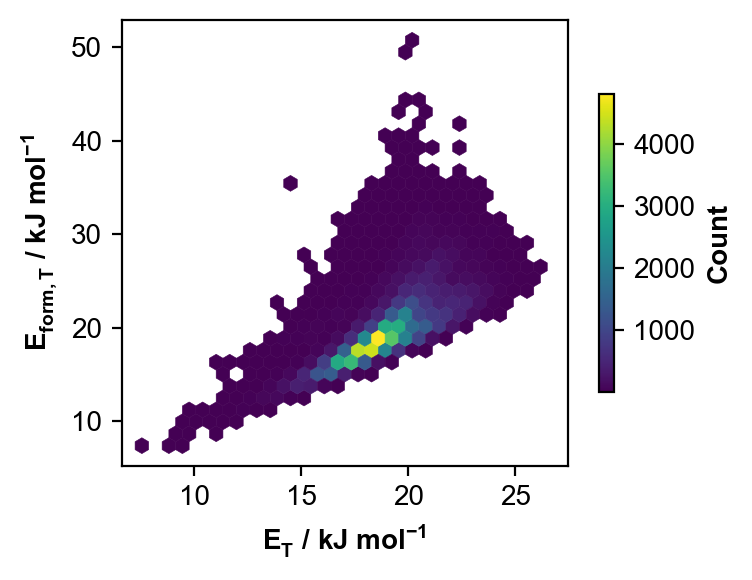

In [35]:
fig, ax = plt.subplots(figsize=(4, 3))

im = ax.hexbin(dsk_df["E_T"], dsk_df["E_fT"], gridsize=30, cmap="viridis", mincnt=1, linewidths=0.2)
cbar = plt.colorbar(im, shrink=0.67)
cbar.set_label("Count", fontweight="bold")
ax.set_xlabel(
    "$\mathdefault{E_{T}}$ / kJ mol$^{\mathdefault{-1}}$",  # noqa: W605
    fontweight="bold",
)
ax.set_ylabel("$\mathdefault{E_{form,T}}$ / kJ mol$^{\mathdefault{-1}}$", fontweight="bold")  # noqa: W605,
ax.set_box_aspect(1)
fig.tight_layout()

In [36]:
dsk_df.columns

Index(['crystal_id', 'Zeolite', 'SMILES', 'Ligand formula', 'Loading', 'dE_S',
       'dE_Om', 'Directivity (SiO2)', 'Competition (SiO2)',
       'Competition (OSDA)', 'Templating', 'Volume (Angstrom3)', 'syn',
       'ligand_atoms', 'dE_Oa', 'E_F', 'entropy_trans', 'entropy_rot',
       'symmetry', 'dS_ads', 'Si_count', 'TdS_ads', 'dA_Om', 'dA_S', 'dA_Oa',
       'dA_fS', 'dE_fOm', 'dE_fOa', 'dE_fS', 'C_Oa', 'C_Om', 'C_S', 'D_Oa',
       'D_Om', 'D_S', 'C_AOa', 'C_AOm', 'C_AS', 'D_AOa', 'D_AOm', 'D_AS',
       'C_fOa', 'C_fOm', 'C_fS', 'D_fOa', 'D_fOm', 'D_fS', 'E_T', 'E_fT',
       'A_T'],
      dtype='object')

In [37]:
log_columns = [
    "C_Oa",
    "C_Om",
    "C_S",
    "D_Oa",
    "D_Om",
    "D_S",
    "C_AOa",
    "C_AOm",
    "C_AS",
    "D_AOa",
    "D_AOm",
    "D_AS",
    "C_fOa",
    "C_fOm",
    "C_fS",
    "D_fOa",
    "D_fOm",
    "D_fS",
]
for cc in log_columns:
    new_col = f"l{cc}"
    dsk_df[new_col] = np.log(dsk_df[cc])

dsk_df.columns

/home/ajhoffman/miniforge3/envs/htvs/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ajhoffman/miniforge3/envs/htvs/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Index(['crystal_id', 'Zeolite', 'SMILES', 'Ligand formula', 'Loading', 'dE_S',
       'dE_Om', 'Directivity (SiO2)', 'Competition (SiO2)',
       'Competition (OSDA)', 'Templating', 'Volume (Angstrom3)', 'syn',
       'ligand_atoms', 'dE_Oa', 'E_F', 'entropy_trans', 'entropy_rot',
       'symmetry', 'dS_ads', 'Si_count', 'TdS_ads', 'dA_Om', 'dA_S', 'dA_Oa',
       'dA_fS', 'dE_fOm', 'dE_fOa', 'dE_fS', 'C_Oa', 'C_Om', 'C_S', 'D_Oa',
       'D_Om', 'D_S', 'C_AOa', 'C_AOm', 'C_AS', 'D_AOa', 'D_AOm', 'D_AS',
       'C_fOa', 'C_fOm', 'C_fS', 'D_fOa', 'D_fOm', 'D_fS', 'E_T', 'E_fT',
       'A_T', 'lC_Oa', 'lC_Om', 'lC_S', 'lD_Oa', 'lD_Om', 'lD_S', 'lC_AOa',
       'lC_AOm', 'lC_AS', 'lD_AOa', 'lD_AOm', 'lD_AS', 'lC_fOa', 'lC_fOm',
       'lC_fS', 'lD_fOa', 'lD_fOm', 'lD_fS'],
      dtype='object')

In [38]:
mdf = dsk_df[
    [
        "crystal_id",
        "Zeolite",
        "SMILES",
        "Ligand formula",
        "Loading",
        "dE_S",
        "dE_Om",
        "Templating",
        "Volume (Angstrom3)",
        "syn",
        "TdS_ads",
        "ligand_atoms",
        "dE_Oa",
        "E_F",
        "Si_count",
        "dA_Om",
        "dA_Oa",
        "dA_S",
        "dE_fOm",
        "dE_fOa",
        "dE_fS",
        "dA_fS",
        "E_T",
        "E_fT",
        "A_T",
        "lC_Oa",
        "lC_S",
        "lD_Oa",
        "lD_S",
        "lC_AOa",
        "lC_AS",
        "lD_AOa",
        "lD_AS",
        "lC_fOa",
        "lC_fS",
        "lD_fOa",
        "lD_fS",
        "lC_Om",
        "lD_Om",
        "lC_AOm",
        "lD_AOm",
        "lC_fOm",
        "lD_fOm",
    ]
]

In [39]:
mdf.head()

,crystal_id,Zeolite,SMILES,Ligand formula,Loading,dE_S,dE_Om,Templating,Volume (Angstrom3),syn,...,lC_fOa,lC_fS,lD_fOa,lD_fS,lC_Om,lD_Om,lC_AOm,lD_AOm,lC_fOm,lD_fOm
0,137337790,ACO,CCCCCN,C5H13N,2,-0.792990,-6.343916,19.428617,107.680,0.0,...,-3.763081,-5.177063,-5.462692,-7.613363,-21.215128,-40.662536,-24.096644,-51.616742,-32.810746,-36.236019
1,137353625,ACO,Cc1ccncc1,C6H7N,2,-3.000776,-24.006207,18.325914,96.232,0.0,...,-3.998696,-4.513224,-5.956683,-7.434522,-15.904415,-33.432341,-18.533953,-43.677207,-27.500033,-36.977180
2,137369986,ACO,NCCOCCO,C4H11NO2,3,-7.733204,-41.243755,15.525417,108.720,0.0,...,-2.634592,-3.090273,-4.440724,-5.831656,-10.721414,-33.119391,-14.687604,-43.094288,-10.776070,-20.026711
3,137352553,ACO,CCNCC,C4H11N,2,-2.536347,-20.290778,18.026902,91.104,0.0,...,-3.823833,-4.652868,-5.517742,-7.004148,-17.021574,-29.886585,-18.562155,-39.813323,-28.617192,-30.623784
4,139638010,ACO,CCCCN,C4H11N,3,-1.885987,-10.058597,19.195592,90.800,0.0,...,-3.294812,-4.848419,-5.252069,-7.667084,-20.098195,-38.772090,-21.736081,-45.225110,-20.152850,-27.230365


In [40]:
mdf.to_csv("../data/clean_all_data.csv", index=False)